# Agent Chat with Huggingface Models

## Set up the environment

In [1]:
%pip install huggingface_hub Pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import re

import PIL

import autogen
from autogen import UserProxyAgent
from autogen.agentchat.contrib.huggingface_agent import HuggingFaceAgent, HuggingFaceCapability
from autogen.agentchat.contrib.img_utils import get_pil_image
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

/home/weitian/anaconda3/envs/autogen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, we need to specify the configurations for the HuggingFace models we want to use, like the model ID, API key, and inference mode. We can do this by extending the `OAI_CONFIG_LIST`.

The `config_list` of HuggingFace models in `OAI_CONFIG_LIST` should be something like:

```python
[
    {
        "model": "<HF_MODEL_ID_OR_URL>",
        "api_key": "<HF_API_KEY>",
        "inference_mode": "auto", # choose from ["local", "remote", "auto"]
        "api_type": "HuggingFace",
        "tags": ["<HF_TASK>"]
    }
]
```

In this sample notebook, we will use:
- the [stabilityai/sdxl-turbo](https://huggingface.co/stabilityai/sdxl-turbo) model for `text-to-image` task
- the [Salesforce/blip-image-captioning-base](https://huggingface.co/Salesforce/blip-image-captioning-base) model for `image-to-text` task
- the [stabilityai/stable-diffusion-xl-refiner-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-refiner-1.0) model for `image-to-image` task
- the [dandelin/vilt-b32-finetuned-vqa](https://huggingface.co/dandelin/vilt-b32-finetuned-vqa) model for `visual-question-answering` task.

In [3]:
gpt4_config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={"model": ["gpt-4"]},
)

gpt4v_config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={"model": ["gpt-4-turbo-vision"]},
)

text2image_config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST", filter_dict={"api_type": ["huggingface"], "tags": ["text-to-image"]}
)

image2text_config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST", filter_dict={"api_type": ["huggingface"], "tags": ["image-to-text"]}
)

image2image_config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST", filter_dict={"api_type": ["huggingface"], "tags": ["image-to-image"]}
)

vqa_config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST", filter_dict={"api_type": ["huggingface"], "tags": ["visual-question-answering"]}
)

We will create a config map with the key as one of the `HuggingFaceCapability`, and the value as the model config for the corresponding capability. This map will be later used to create the `HuggingFaceAgent`.

In [4]:
hf_capability_config_map = {
    HuggingFaceCapability.TEXT_TO_IMAGE: {"config_list": text2image_config_list},
    HuggingFaceCapability.IMAGE_TO_TEXT: {"config_list": image2text_config_list},
    HuggingFaceCapability.IMAGE_TO_IMAGE: {"config_list": image2image_config_list},
    HuggingFaceCapability.VISUAL_QUESTION_ANSWERING: {"config_list": vqa_config_list},
}

## Helper Functions

Here is a helper function to extract images from the messages.

In [5]:
def extract_images(sender: autogen.ConversableAgent, recipient: autogen.ConversableAgent) -> PIL.Image:
    images = []
    all_messages = sender.chat_messages[recipient]

    for message in reversed(all_messages):
        # The GPT-4V format, where the content is an array of data
        contents = message.get("content", "")
        if isinstance(contents, str):
            for img_data in re.findall("<img (.*)>", contents):
                images.append(get_pil_image(img_data))
        else:
            for content in contents:
                if isinstance(content, str):
                    continue
                if content.get("type", "") == "image_url":
                    img_data = content["image_url"]["url"]
                    images.append(get_pil_image(img_data))

    if not images:
        raise ValueError("No image data found in messages.")

    return images

## Simple Example: Call directly from User

In [6]:
assistant = HuggingFaceAgent(
    name="multimodal_assistant",
    hf_capability_config_map=hf_capability_config_map,
    llm_config={"config_list": gpt4v_config_list, "max_tokens": 400},
    is_gpt4v_format=True,
    # is_silent=False,
)

user_proxy = UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    code_execution_config=False,
    default_auto_reply="",
    is_termination_msg=lambda x: True,
)

### Text-To-Image

We can ask the `HuggingFaceAgent` to create an image with a text prompt.

In [7]:
user_proxy.initiate_chat(
    assistant,
    message="Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'. Make sure the text is clear.",
)

user_proxy (to multimodal_assistant):

Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'. Make sure the text is clear.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION TEXT_TO_IMAGE...
multimodal_assistant (to user_proxy):

Here is the image you requested:

<image>

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': "Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'. Make sure the text is clear.", 'role': 'assistant'}, {'content': [{'type': 'text', 'text': 'Here is the image you requested:\n\n'}, {'type': 'image_url', 'image_url': {'url': <PIL.Image.Image image mode=RGB size=512x512 at 0x70862C186590>}}, {'type': 'text', 'text': ''}], 'role': 'user'}], summary='Here is the image you requested:\n\n\n', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

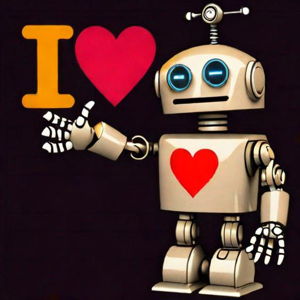

In [8]:
images = extract_images(assistant, user_proxy)

for image in reversed(images):
    display(image.resize((300, 300)))

### Image-To-Text

We can also ask the `HuggingFaceAgent` to describe the content of an image.

In [9]:
user_proxy.initiate_chat(
    assistant,
    message="""Write a poet for my image:
    <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""",
)

user_proxy (to multimodal_assistant):

Write a poet for my image:
    <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION IMAGE_TO_TEXT...
multimodal_assistant (to user_proxy):

Beneath the whisper of a gentle breeze,
Amidst the hum of serene abode,
A little brown furball softly lays,
In the quiet embrace of a peaceful close.

Its eyes half-closed in tranquil dreams,
Whiskers twitch at imagined chases,
As paws twitch with the adventures unseen,
In lands of endless, rolling spaces.

Snoozing away the lazy hours,
Embraced by shadows and the ticking clock,
It finds solace on the cool, hard floor,
Unmoved by time's persistent knock.

Oh, tender creature with the spirit light,
Teach me the art of resting heart,
To live as simply, to rest as tight,
In life's canvas, to be a gentle part.

--------------

ChatResult(chat_id=None, chat_history=[{'content': 'Write a poet for my image:\n    <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.', 'role': 'assistant'}, {'content': [{'type': 'text', 'text': "Beneath the whisper of a gentle breeze,\nAmidst the hum of serene abode,\nA little brown furball softly lays,\nIn the quiet embrace of a peaceful close.\n\nIts eyes half-closed in tranquil dreams,\nWhiskers twitch at imagined chases,\nAs paws twitch with the adventures unseen,\nIn lands of endless, rolling spaces.\n\nSnoozing away the lazy hours,\nEmbraced by shadows and the ticking clock,\nIt finds solace on the cool, hard floor,\nUnmoved by time's persistent knock.\n\nOh, tender creature with the spirit light,\nTeach me the art of resting heart,\nTo live as simply, to rest as tight,\nIn life's canvas, to be a gentle part."}], 'role': 'user'}], summary="Beneath the whisper of a gentle breeze,\nAmidst the hum of serene abode,\nA little bro

### Visual-Question_Answering

We can also ask the `HuggingFaceAgent` to answer a question based on the content of the image.

We will show this image and ask a follow-up question.

![test_img](https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1)

In [10]:
user_proxy.initiate_chat(
    assistant,
    message="""What is this breed?
<img https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1>

Among the breeds, which one barks less?""",
)

user_proxy (to multimodal_assistant):

What is this breed?
<img https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1>

Among the breeds, which one barks less?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION VISUAL_QUESTION_ANSWERING...
multimodal_assistant (to user_proxy):

The dog in the image is a Husky.

Among the breeds, generally, Greyhounds are known to bark less compared to Huskies, which can be quite vocal.

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'What is this breed?\n<img https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1>\n\nAmong the breeds, which one barks less?', 'role': 'assistant'}, {'content': [{'type': 'text', 'text': 'The dog in the image is a Husky.\n\nAmong the breeds, generally, Greyhounds are known to bark less compared to Huskies, which can be quite vocal.'}], 'role': 'user'}], summary='The dog in the image is a Husky.\n\nAmong the breeds, generally, Greyhounds are known to bark less compared to Huskies, which can be quite vocal.', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

## Example With Critics: Iterate several times to improve

In [11]:
CRITICS_SYSTEM_MESSAGE = """You need to improve the prompt of the figures you saw.
How to create an image that is better in terms of color, shape, text (clarity), and other things.
Reply with the following format:

CRITICS: the image needs to improve...
PROMPT: here is the updated prompt!

If you have no critique or a prompt, just say TERMINATE
"""


def _is_termination_message(msg) -> bool:
    # Detects if we should terminate the conversation
    if isinstance(msg.get("content"), str):
        return msg["content"].rstrip().endswith("TERMINATE")
    elif isinstance(msg.get("content"), list):
        for content in msg["content"]:
            if isinstance(content, dict) and "text" in content:
                return content["text"].rstrip().endswith("TERMINATE")
    return False


critic_agent = MultimodalConversableAgent(
    name="critic",
    llm_config={"config_list": gpt4v_config_list, "max_tokens": 400},
    system_message=CRITICS_SYSTEM_MESSAGE,
    max_consecutive_auto_reply=1,
    human_input_mode="NEVER",
    is_termination_msg=lambda msg: _is_termination_message(msg),
)

image_creator = HuggingFaceAgent(
    name="image_creator",
    hf_capability_config_map=hf_capability_config_map,
    llm_config={"config_list": gpt4v_config_list, "max_tokens": 400},
    is_gpt4v_format=True,
    is_termination_msg=lambda msg: _is_termination_message(msg),
)

In [12]:
critic_agent.initiate_chat(
    image_creator,
    message="Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'. Make sure the text is clear.",
)

critic (to image_creator):

Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'. Make sure the text is clear.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION TEXT_TO_IMAGE...
image_creator (to critic):

Here is the image of a happy robot holding a sign that says 'I Love AutoGen' against a black background:

<image>

--------------------------------------------------------------------------------
critic (to image_creator):

CRITICS: The image needs to improve the contrast and brightness on the robot for it to stand out more vividly against the black background. The "I Love AutoGen" sign could be more dynamic with sharper and bolder text to enhance readability.

PROMPT: Create an image with a richer and more detailed depiction of a happy robot against a dark black background. The robot should have a more metallic and glossy texture to contrast sharply with

ChatResult(chat_id=None, chat_history=[{'content': [{'type': 'text', 'text': "Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'. Make sure the text is clear."}], 'role': 'assistant'}, {'content': [{'type': 'text', 'text': "Here is the image of a happy robot holding a sign that says 'I Love AutoGen' against a black background:\n\n"}, {'type': 'image_url', 'image_url': {'url': <PIL.Image.Image image mode=RGB size=512x512 at 0x7085DB3D3D10>}}, {'type': 'text', 'text': ''}], 'role': 'user'}, {'content': [{'type': 'text', 'text': 'CRITICS: The image needs to improve the contrast and brightness on the robot for it to stand out more vividly against the black background. The "I Love AutoGen" sign could be more dynamic with sharper and bolder text to enhance readability.\n\nPROMPT: Create an image with a richer and more detailed depiction of a happy robot against a dark black background. The robot should have a more metallic and glossy texture to contr

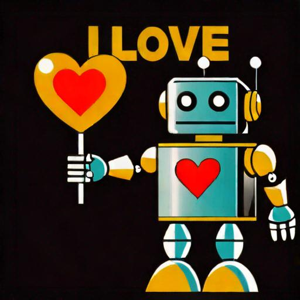

In [13]:
images = extract_images(image_creator, critic_agent)

display(images[0].resize((300, 300)))